In [1]:
import pandas as pd
import numpy as np
import pylab as pl
import geopandas as gpd
import matplotlib as mpl
import os
import shapely
import collections
from fiona.crs import from_epsg


from get_jsonparsed_data import get_jsonparsed_data # must have this function locally or in path

import choroplathNYC as cp

%pylab inline
pl.rcParams['font.size'] = 20


Populating the interactive namespace from numpy and matplotlib


# NYC zipcodes and census tracts geometry

In [3]:
zips = gpd.GeoDataFrame.from_file("data/ZIP_CODE_040114.shp")
zips = zips.to_crs(epsg=4326)
NYgeodata = gpd.GeoDataFrame.from_file("data/cb_2014_36_tract_500k/cb_2014_36_tract_500k.shp")


# language data from American Community Survey 2015 and 2010
 we assume the relevant languages are 
 "Hindi", "Urdu", "Arabic", and "Other_Indic_languages"

## pre processed data by Jill Hubley 2015

In [4]:
languageBd = pd.read_csv("data/languages_all1.csv")
languageBd['tot']  = languageBd.iloc[:,1:].sum(axis=1)
#languageBd['tot'] = languageBd[:,2:]
languageBd['allrelev'] = languageBd[["Hindi", "Urdu", "Arabic"]].astype(float).sum(axis=1)
languageBd.drop(languageBd.columns[5:-2], axis=1, inplace=True)

In [ ]:
languageBd.head()


## Arab population by numbers 2015

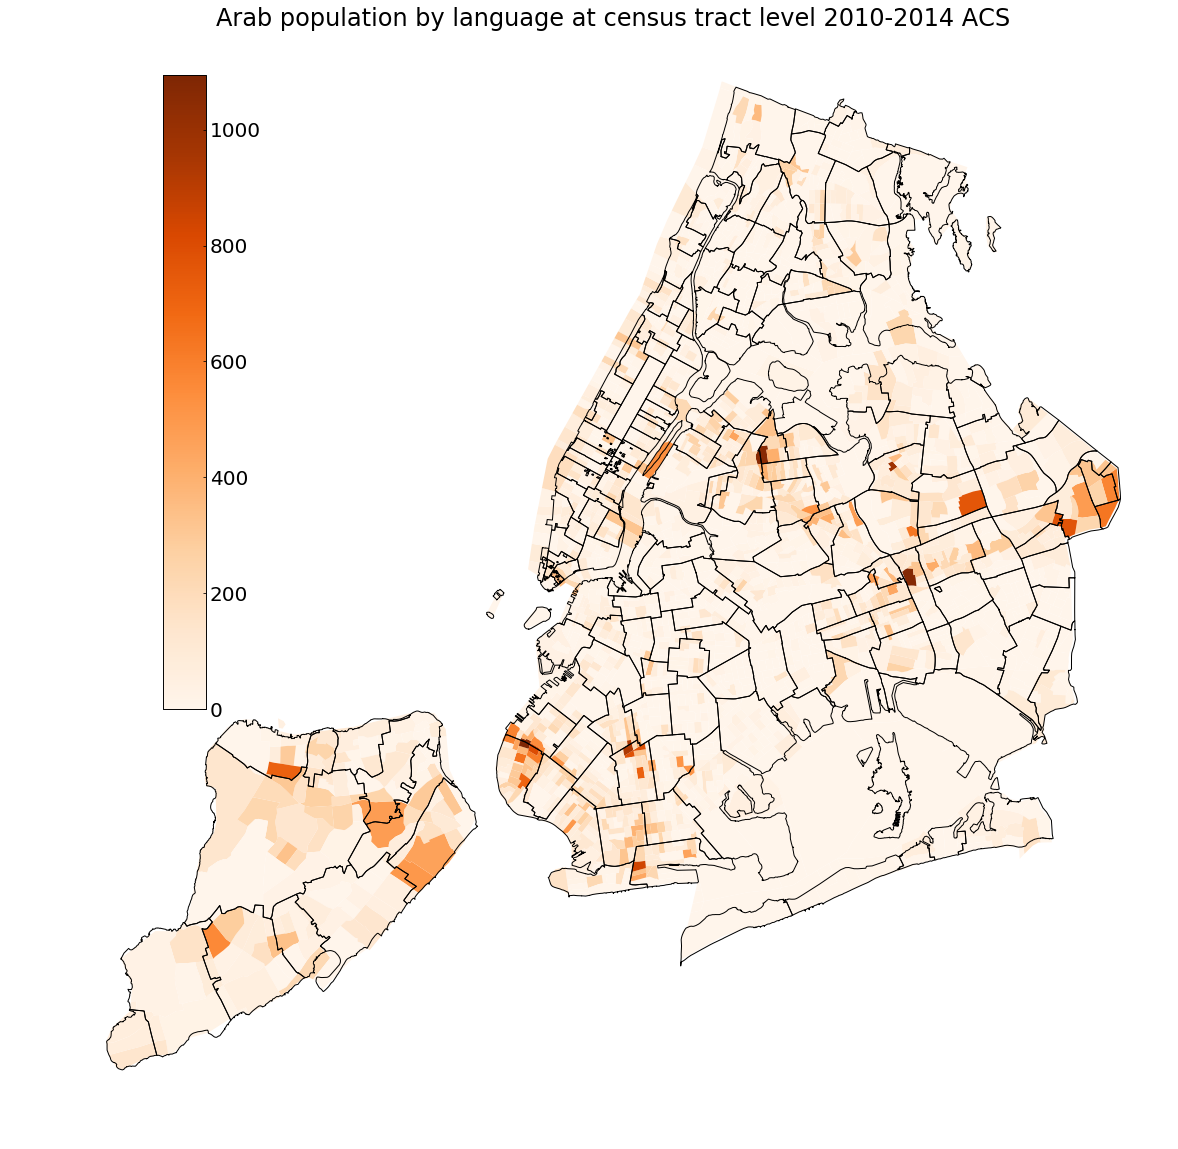

In [5]:
fig = pl.figure(figsize=(20,20))
ax = fig.add_subplot(111)

geoLanguage = NYgeodata.merge(languageBd, how="inner", right_on="id", left_on=u'AFFGEOID')#.plot(figsize = (20,20), column='allrelev')
#.drop(["id"], inplace=True)

f, ax = cp.choroplethNYC(geoLanguage, "allrelev", kind='continuous', cmap="Oranges", ax=ax, lw=0)
title = ax.set_title("Arab population by language at census tract level 2010-2014 ACS")
zips.plot(ax=ax, column=None, facecolor='none')
pl.savefig("ArabCountByLanguage15.png")

In [6]:
# caluclating fractions
geoLanguage['fraction'] = geoLanguage[['allrelev']].astype(float).values / geoLanguage[['tot']].astype(float).values
geoLanguage['fractionArabic'] = geoLanguage[['Arabic']].astype(float).values / geoLanguage[['tot']].astype(float).values
geoLanguage['fractionHindi'] = geoLanguage[['Hindi']].astype(float).values / geoLanguage[['tot']].astype(float).values
geoLanguage['fractionUrdu'] = geoLanguage[['Urdu']].astype(float).values / geoLanguage[['tot']].astype(float).values
geoLanguage['fractionOther'] = geoLanguage[['Other_Indic_languages']].astype(float).values / geoLanguage[['tot']].astype(float).values

In [7]:
geoLanguage.columns

Index([             u'AFFGEOID',                 u'ALAND',
                      u'AWATER',              u'COUNTYFP',
                       u'GEOID',                  u'LSAD',
                        u'NAME',               u'STATEFP',
                     u'TRACTCE',              u'geometry',
                          u'id',                u'Arabic',
                       u'Hindi',                  u'Urdu',
       u'Other_Indic_languages',                   u'tot',
                    u'allrelev',              u'fraction',
              u'fractionArabic',         u'fractionHindi',
                u'fractionUrdu',         u'fractionOther'],
      dtype='object')

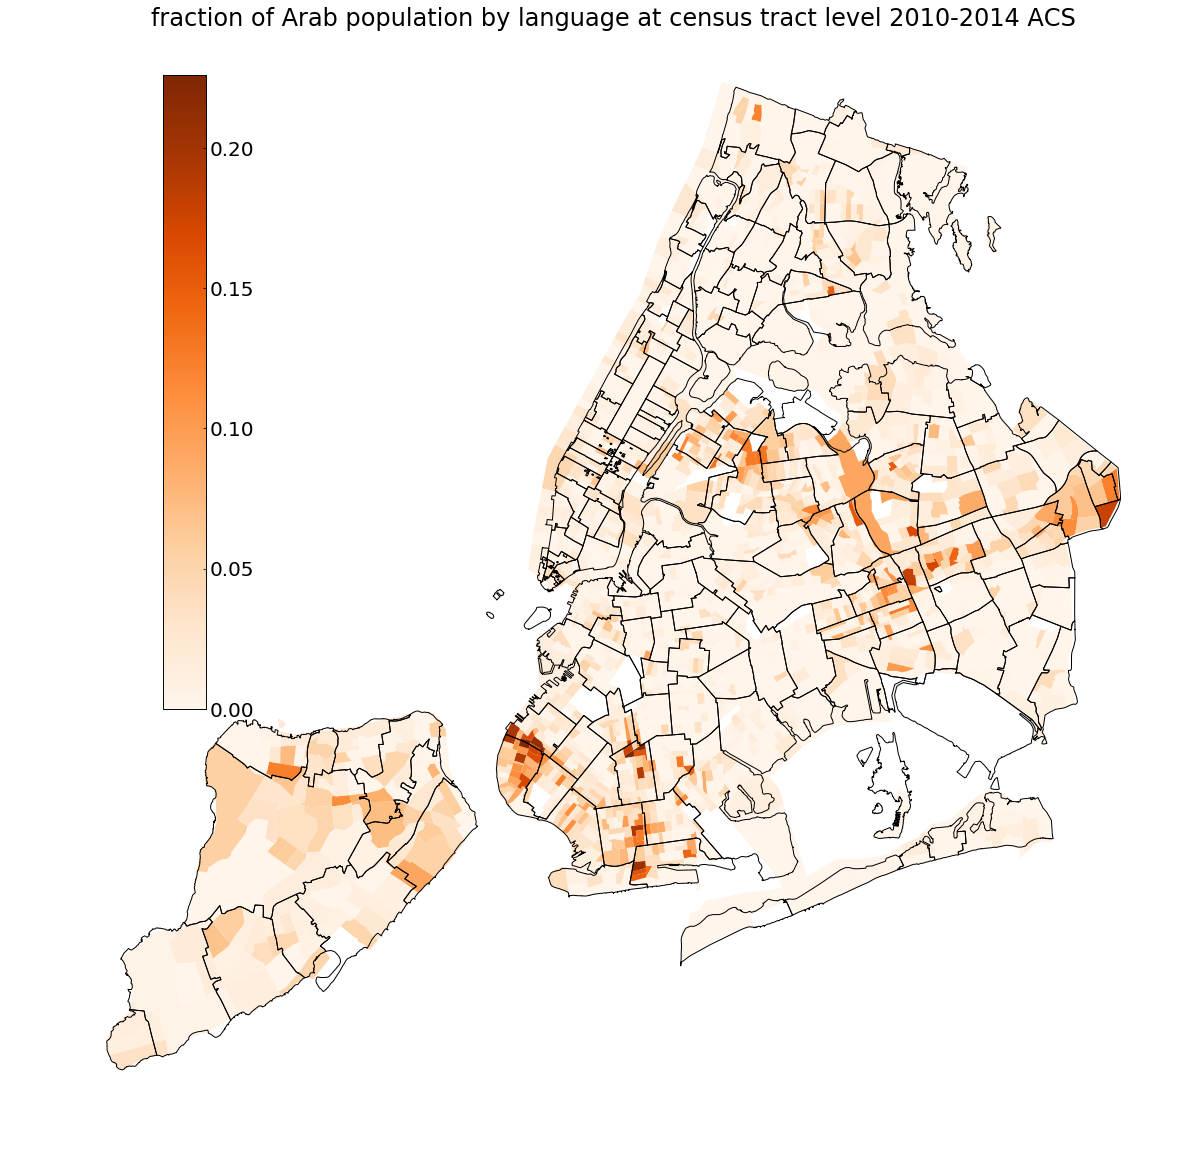

In [8]:
fig = pl.figure(figsize=(20,20))
ax = fig.add_subplot(111)

#.drop(["id"], inplace=True)

f, ax = cp.choroplethNYC(geoLanguage, "fraction", kind='continuous', cmap="Oranges", ax=ax, lw = 0)
ax.set_title("fraction of Arab population by language at census tract level 2010-2014 ACS")
zips.plot(ax=ax, column=None, facecolor='none')

pl.savefig("ArabByLanguage15.png")

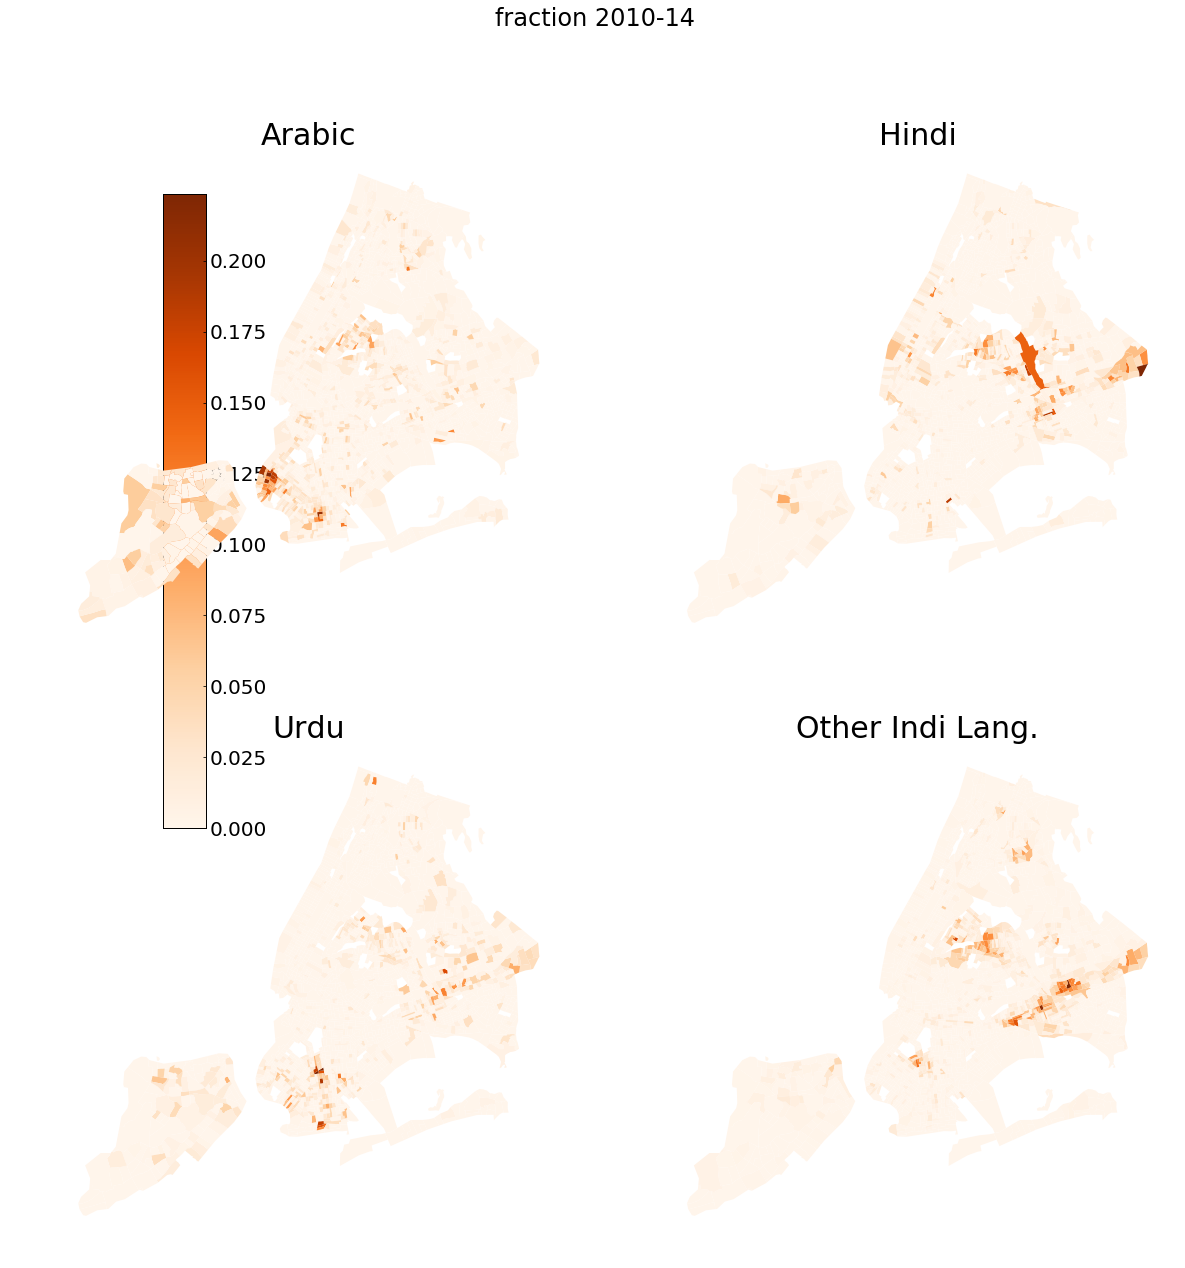

In [9]:
fig = pl.figure(figsize=(20,20))
ax = fig.add_subplot(224)
f, ax = cp.choroplethNYC(geoLanguage, "fractionOther", kind='continuous', cmap="Oranges", ax=ax, lw = 0)
ax.set_title("Other Indi Lang.", fontsize=30)


ax = fig.add_subplot(221)

f, ax = cp.choroplethNYC(geoLanguage, "fractionArabic", kind='continuous', cmap="Oranges", ax=ax, lw = 0)
ax.set_title("Arabic", fontsize=30)

ax = fig.add_subplot(222)

f, ax = cp.choroplethNYC(geoLanguage, "fractionHindi", kind='continuous', cmap="Oranges", ax=ax, lw = 0)
ax.set_title("Hindi", fontsize=30)


ax = fig.add_subplot(223)

f, ax = cp.choroplethNYC(geoLanguage, "fractionUrdu", kind='continuous', cmap="Oranges", ax=ax, lw = 0)
ax.set_title("Urdu", fontsize=30)
pl.suptitle('fraction 2010-14')
pl.savefig('fraction4Languages15.png')


## ACS 2010 data

In [10]:
# TODO aggregate at zipcode level
columns = ['GEO.id', 'HD01_VD108', 'HD01_VD54', 'HD01_VD57', 'HD01_VD60', 'HD01_VD01'] #pd.read
language2010 = pd.read_csv("data/ACS_10_5YR_B16001_with_ann.csv", usecols = columns)
language2010.rename(columns={'GEO.id':"id","HD01_VD108":"Arabic","HD01_VD54":"Hindi",
                             "HD01_VD57":"Urdu", 'HD01_VD01':'tot',
                             "HD01_VD60":"Other_Indic_languages"}, inplace=True)
language2010.drop(0, inplace=True)
language2010['allrelev'] = language2010[["Hindi", "Urdu", "Arabic"]].astype(float).sum(axis=1)
language2010.head()

id    tot Hindi Urdu Other_Indic_languages Arabic  \
1  1400000US36005000100  11517     0    0                    16      9   
2  1400000US36005000200   4014     0   23                   139      0   
3  1400000US36005000400   4640     0   66                     0     21   
4  1400000US36005001600   4793     0    0                     0      0   
5  1400000US36005001900   2013     0    0                     0      0   

   allrelev  
1       9.0  
2      23.0  
3      87.0  
4       0.0  
5       0.0

In [11]:
geoLanguage2010 = NYgeodata.merge(language2010, how="inner", right_on="id", left_on=u'AFFGEOID')#.plot(figsize = (20,20), column='allrelev')
geoLanguage2010.columns
geoLanguage2010['fraction'] = geoLanguage2010[['allrelev']].astype(float).values / geoLanguage2010[['tot']].astype(float).values
geoLanguage2010['fractionArabic'] = geoLanguage2010[['Arabic']].astype(float).values / geoLanguage2010[['tot']].astype(float).values
geoLanguage2010['fractionHindi'] = geoLanguage2010[['Hindi']].astype(float).values / geoLanguage2010[['tot']].astype(float).values
geoLanguage2010['fractionUrdu'] = geoLanguage2010[['Urdu']].astype(float).values / geoLanguage2010[['tot']].astype(float).values

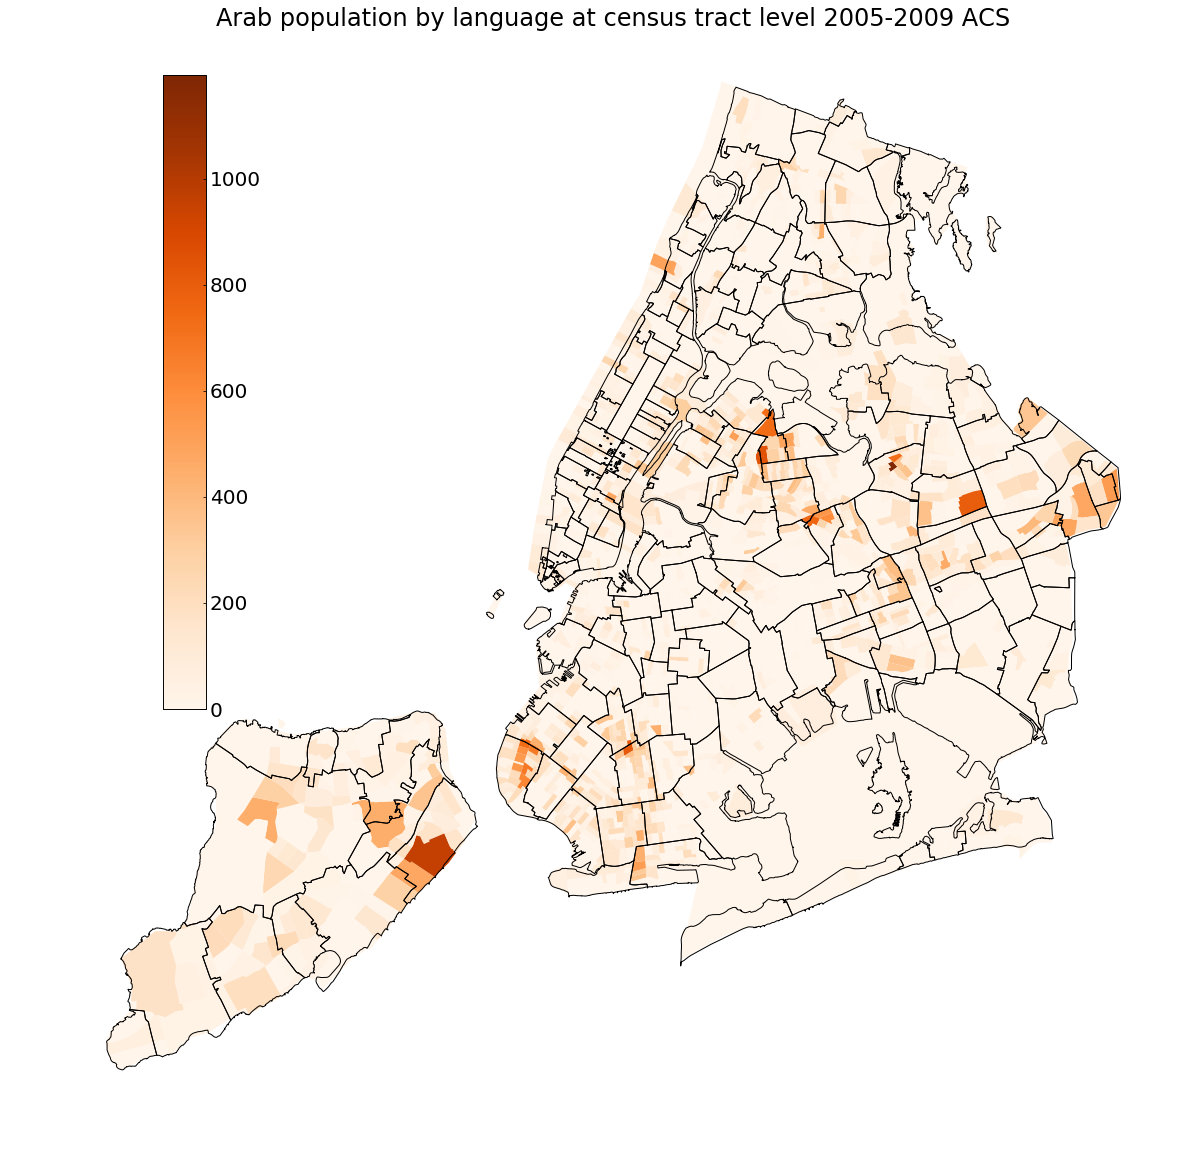

In [12]:
fig = pl.figure(figsize=(20,20))
ax = fig.add_subplot(111)


f, ax = cp.choroplethNYC(geoLanguage2010, "allrelev", kind='continuous', cmap="Oranges", ax=ax, lw=0)
title = ax.set_title("Arab population by language at census tract level 2005-2009 ACS")
zips.plot(ax=ax, column=None, facecolor='none')
pl.savefig("ArabCountByLanguage10.png")

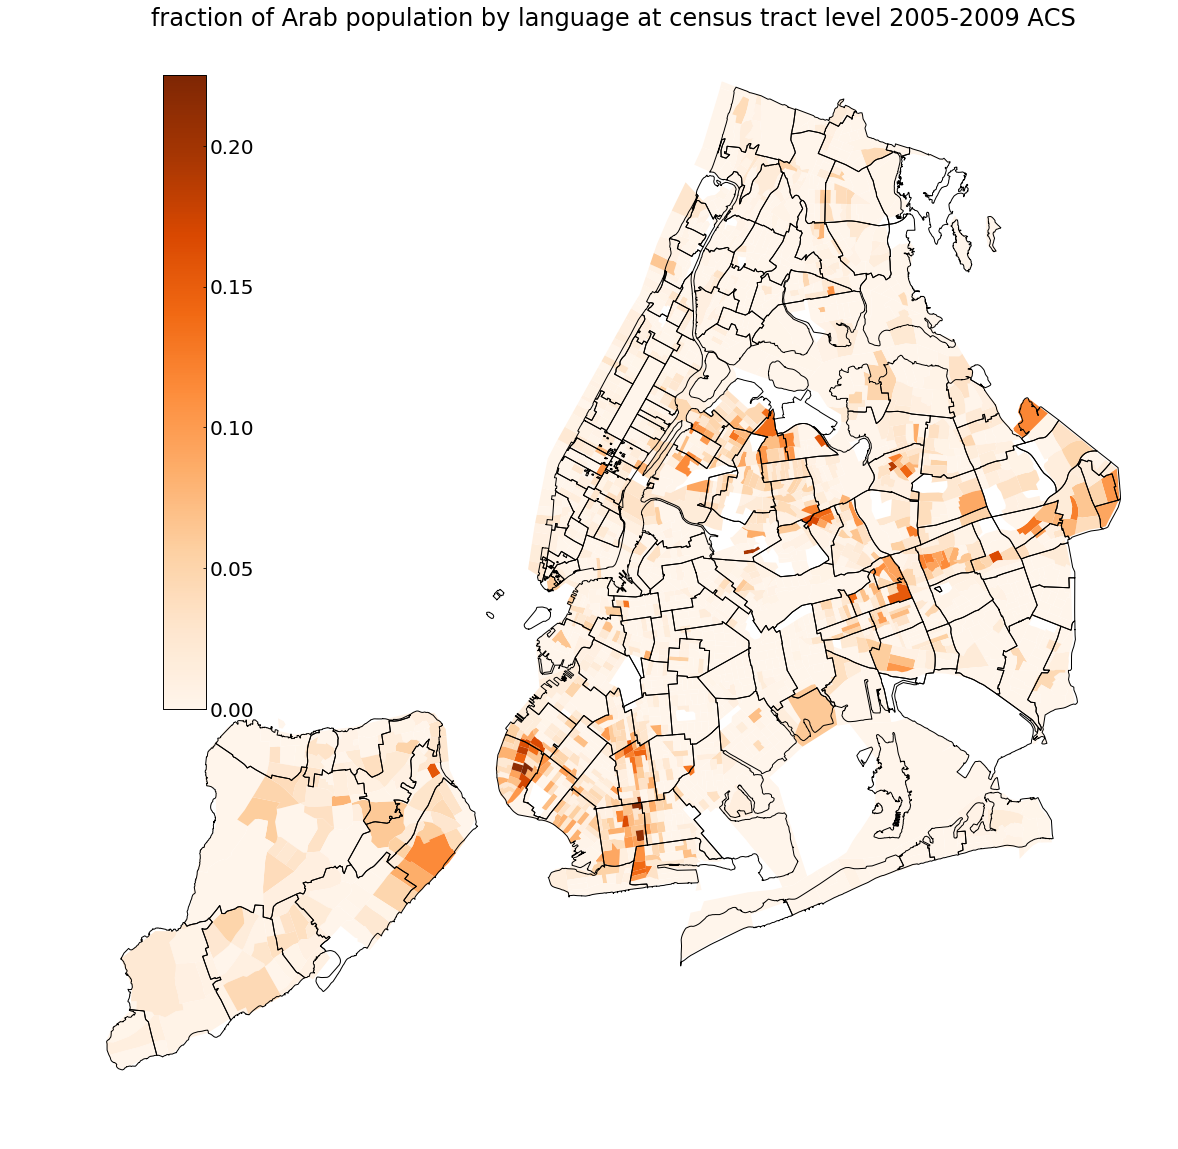

In [13]:
fig = pl.figure(figsize=(20,20))
ax = fig.add_subplot(111)
f, ax = cp.choroplethNYC(geoLanguage2010, "fraction", kind='continuous', cmap="Oranges", ax=ax, lw=0)
title = ax.set_title("fraction of Arab population by language at census tract level 2005-2009 ACS")
zips.plot(ax=ax, column=None, facecolor='none')

pl.savefig("ArabByLanguage10.png")

In [14]:
geoLanguage2010['fractionOther'] = geoLanguage2010[['Other_Indic_languages']].astype(float).values / geoLanguage2010[['tot']].astype(float).values

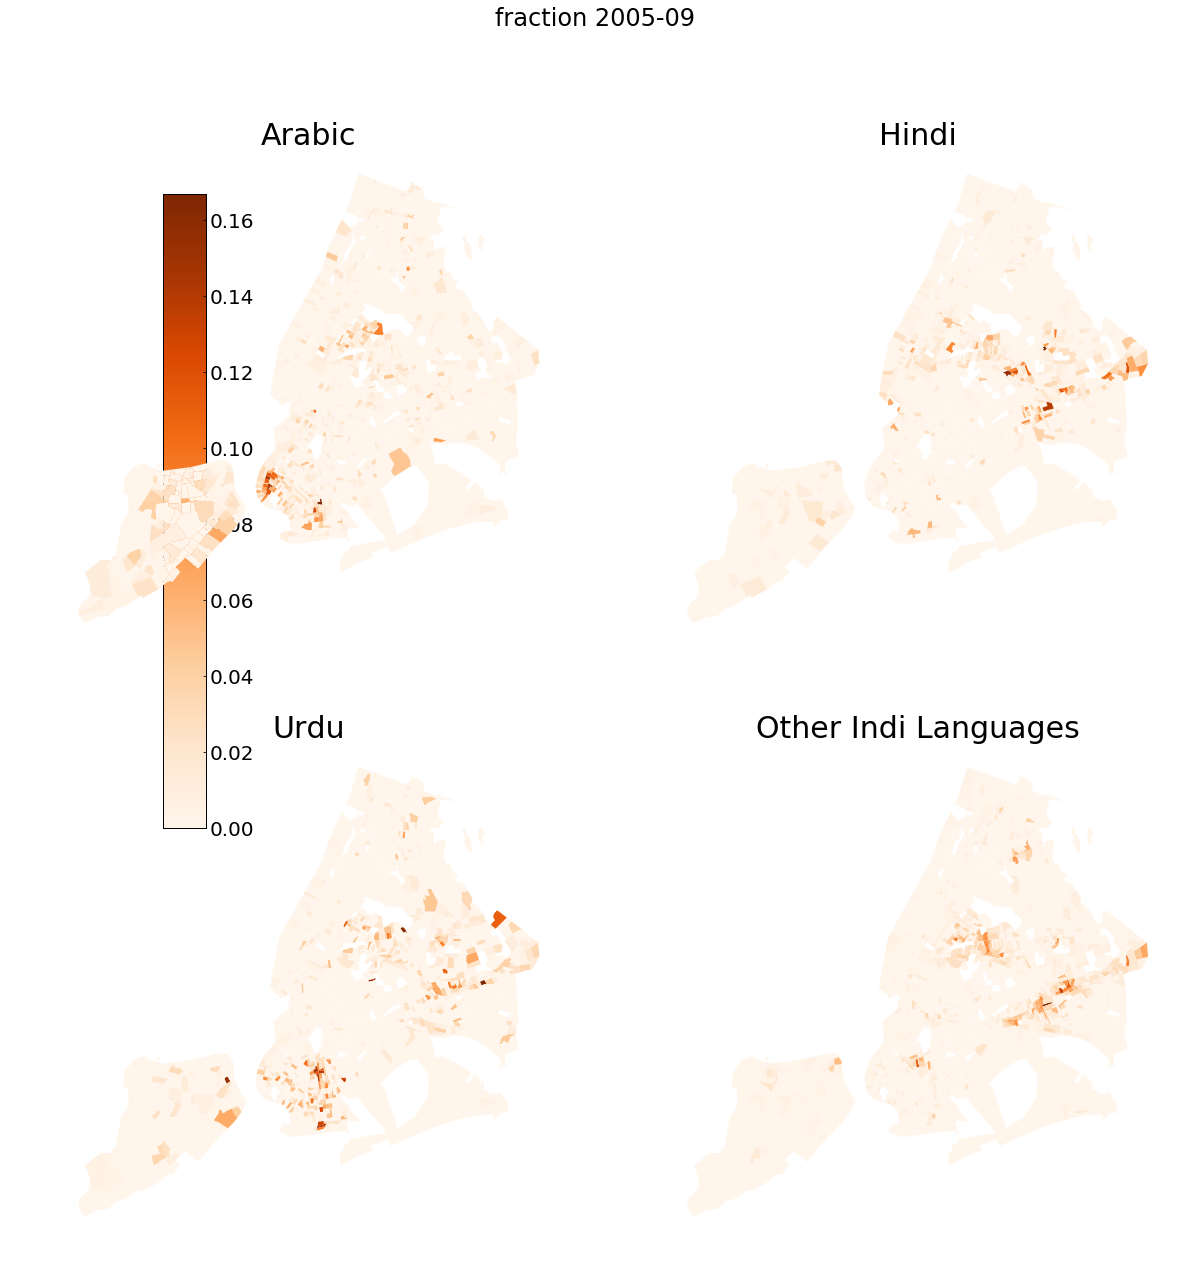

In [15]:
fig = pl.figure(figsize=(20,20))

ax = fig.add_subplot(224)

f, ax = cp.choroplethNYC(geoLanguage2010, "fractionOther", kind='continuous', cmap="Oranges", ax=ax, lw = 0)
ax.set_title("Other Indi Languages", fontsize=30)

ax = fig.add_subplot(221)

f, ax = cp.choroplethNYC(geoLanguage2010, "fractionArabic", kind='continuous', cmap="Oranges", ax=ax, lw = 0)
ax.set_title("Arabic", fontsize=30)

ax = fig.add_subplot(222)

f, ax = cp.choroplethNYC(geoLanguage2010, "fractionHindi", kind='continuous', cmap="Oranges", ax=ax, lw = 0)
ax.set_title("Hindi", fontsize=30)

ax = fig.add_subplot(223)

f, ax = cp.choroplethNYC(geoLanguage2010, "fractionUrdu", kind='continuous', cmap="Oranges", ax=ax, lw = 0)
ax.set_title("Urdu", fontsize=30)
pl.suptitle('fraction 2005-09')

pl.savefig('fraction4Languages10.png')


# time evolution 

In [16]:
geomerged_20102015 = geoLanguage2010.merge(geoLanguage[["id","fraction"]], on="id")
geomerged_20102015["growth"] = geomerged_20102015.fraction_y.astype(float).values - geomerged_20102015.fraction_x.astype(float).values 

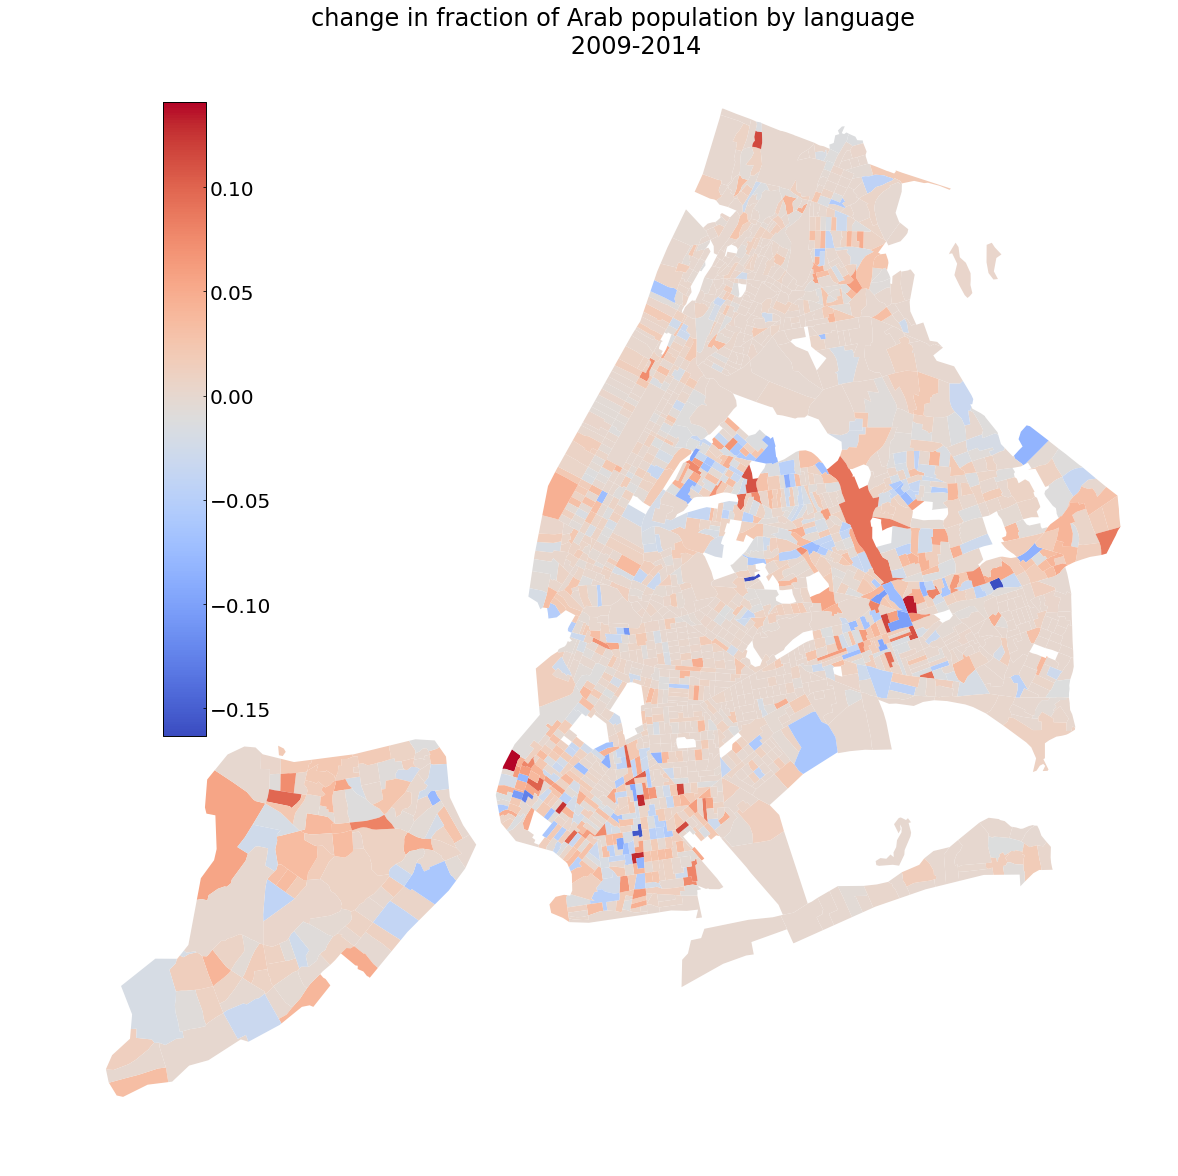

In [18]:
fig = pl.figure(figsize=(20,20))
ax = fig.add_subplot(111)
f, ax = cp.choroplethNYC(geomerged_20102015, "growth", kind='continuous', cmap="coolwarm", ax=ax, lw=0)
title = ax.set_title("change in fraction of Arab population by language\n      2009-2014")
pl.savefig("ArabSpeakersChanges.png")

In [21]:
locations = {
    'l1':{"name":"AAFSC Brooklyn","address":"150 Court Street, 3rd Floor Brooklyn, NY 11201", 'lat':0., 'lng':0.},
    "l2":{"name":"AAFSC Queens", "address":"37-10 30th St, 2nd Fl Long Island City, NY 11101", 'lat':0., 'lng':0.},
    "l3":{"name":"AAFSC Family Justice Center Brooklyn", "address":"350 Jay Street Brooklyn, NY 11201", 'lat':0., 'lng':0.},
    "l4":{"name":"AAFSC Family Justice Center Queens","address":"126-02 82nd Avenue Queens, NY 11415", 'lat':0., 'lng':0.},
    "l5":{"name":"AAFSC Family Justice Center Staten Island","address":"126 Stuyvesant Place Staten Island, NY 10301", 'lat':0., 'lng':0.}
}

for l,loc in locations.iteritems():
    url = "https://maps.googleapis.com/maps/api/geocode/json?address=%s&key=%s"%(loc['address'].replace(" ","+"),os.getenv('GOOGLEAPI'))
    latlon = get_jsonparsed_data(url)["results"][0]['geometry']['location']

    loc['lat'] =  latlon['lat']
    loc['lng'] =  latlon['lng']
    loc['lonlat'] = (loc['lng'],loc['lat'])
    
locationsdf = pd.DataFrame.from_dict(locations, orient='index',)
locationsdf['geometry']=locationsdf[['lonlat']].applymap(lambda x: shapely.geometry.Point(list(x)) )
locationsdf = gpd.GeoDataFrame(locationsdf)

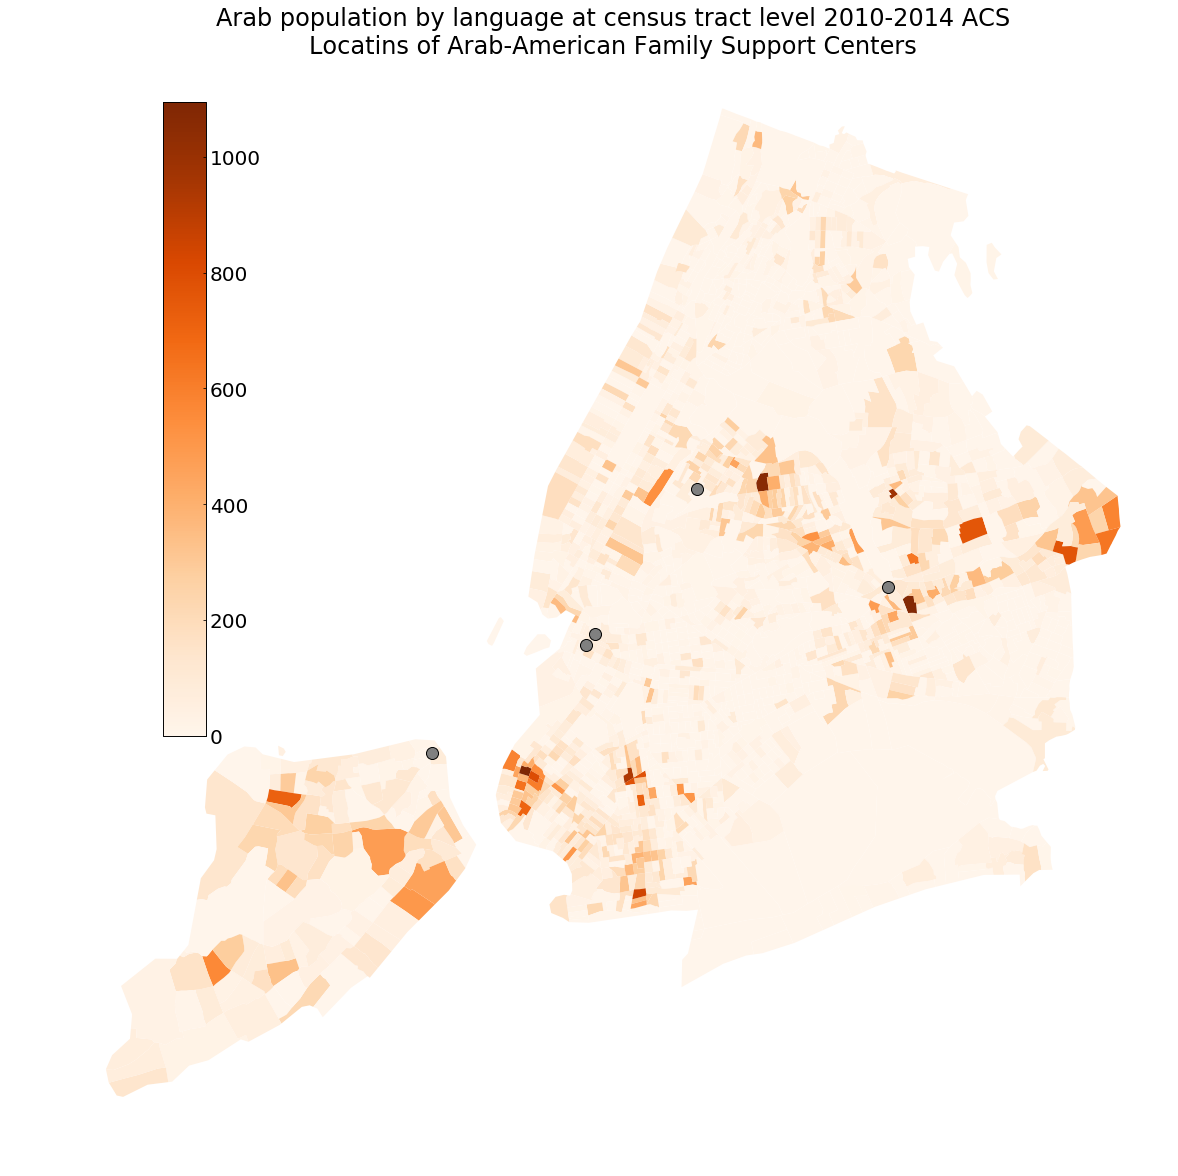

In [22]:
fig = pl.figure(figsize=(20,20))
ax = fig.add_subplot(111)
f, ax = cp.choroplethNYC(geoLanguage, "allrelev", kind='continuous', cmap="Oranges", ax=ax, lw = 0)
locationsdf.plot(ax=ax, marker='o', color='black', markersize=12)
locationsdf.plot(ax=ax, marker='o', color='Gray', markersize=10)
title = ax.set_title("Arab population by language at census tract level 2010-2014 ACS\nLocatins of Arab-American Family Support Centers")
pl.savefig("AAFSClocations.png")